In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

In [2]:
data = pd.read_csv('./example_data.csv')

In [3]:
data

,Unnamed: 0,Date,Time,totalizer_I_avg,totalizer_kW,pump_1_V_avg,pump_1_I_avg,pump_1_kW,pump_2_V_avg,pump_2_I_avg,pump_2_kW
0,0,2021-08-30,00:00:00,20.9708,3.099961,400.5834,0.0,0.0,229.6788,0.0,0.0
1,1,2021-08-30,00:01:00,20.9939,3.101994,400.4940,0.0,0.0,229.7035,0.0,0.0
2,2,2021-08-30,00:02:00,20.9999,3.101498,400.8966,0.0,0.0,229.9250,0.0,0.0
3,3,2021-08-30,00:03:00,21.0313,3.101983,400.8998,0.0,0.0,229.9135,0.0,0.0
4,4,2021-08-30,00:04:00,21.0196,3.103025,400.9295,0.0,0.0,229.8734,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10075,10075,2021-09-05,23:55:00,21.0125,3.154529,399.4004,0.0,0.0,229.0377,0.0,0.0
10076,10076,2021-09-05,23:56:00,21.0139,3.154739,399.4063,0.0,0.0,229.0401,0.0,0.0
10077,10077,2021-09-05,23:57:00,21.0247,3.154977,399.4618,0.0,0.0,229.0785,0.0,0.0
10078,10078,2021-09-05,23:58:00,21.0100,3.155536,399.7240,0.0,0.0,229.2555,0.0,0.0


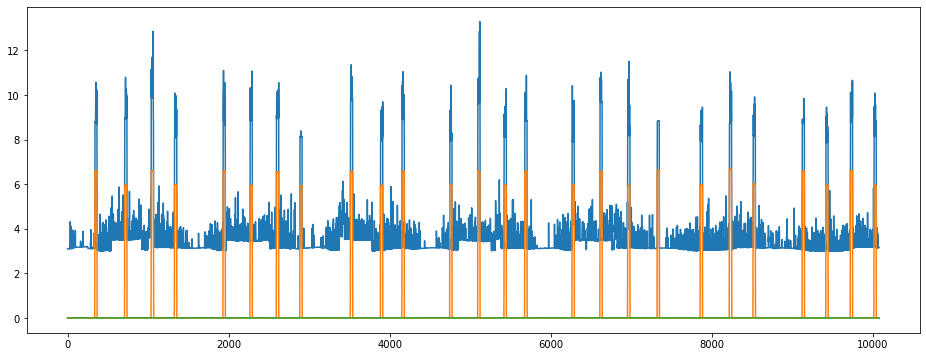

In [4]:
fig = plt.figure()

plt.plot(data['totalizer_kW'])
plt.plot(data['pump_1_kW'])
plt.plot(data['pump_2_kW'])

fig.set_size_inches(16, 6)
plt.show()

In [5]:
def median(data):
    if len(data) % 2 == 1:
        return sorted(data)[len(data) // 2]
    else:
        return sum(sorted(data)[(len(data)//2)-1: (len(data)//2)+1]) / 2
    
def GOF(preevent, detection, alpha):
    """
    Detects if an event occurs
    """
    assert (alpha == 0.01 or alpha == 0.05), 'alpha should be 0.01 or 0,05'
    
    preevent = np.array(preevent)
    detection = np.array(detection)
    
    chisquared = 0
    for i in range (len(preevent)):
        chisquared += ((detection[i] - preevent[i]) ** 2) / preevent[i]

    pvalue = 1 - chi2.cdf(chisquared, len(preevent) - 1)
    return 0 if pvalue > alpha else 1


class On_Off_Event_Detection:
    def __init__(self, data, alpha):
        self.raw_data = data
        self.usp_data = None
        self.mdf_data = None
        self.events = None
        """events_v for visualization"""
        self.events_v = None 
        self.alpha = alpha
        self.diff = None
        
    def upsample(self, data, n):
        usp_data = []
        for i in range (len(data)-1):
            usp_data.append(data[i])
            for j in range (1, n):
                usp_data.append((data[i]*(n-j) + data[i+1]*(j)) / n)
            
        usp_data.append(data[len(data)-1])
        
        self.usp_data = usp_data[:]
        return
        
    def median_filter(self, data, window_size):
        """
        Do median filter on input data, 
            store the result in self.mdf_data
        """
        
        assert (window_size % 2 == 1), "window size shoud be an odd number"
        if window_size == 1:
            self.mdf_data = data[:]
            return
        
        filtered_data = []
        for i in range (len(data)):
            l = max(i - (window_size>>1), 0)
            r = min(i + (window_size>>1), len(data)-1)
            filtered_data.append(median(data[l: r+1]))

        self.mdf_data = filtered_data[:]
        return
    
    def event_detection(self, data, n):
        self.diff = np.diff(data)
        
        length_of_data = len(data)
        cnt = length_of_data // n
        self.events_v = [-1] * length_of_data
        for i in range (cnt-1):
            preevent = data[i*n: (i+1)*n]
            detection = data[(i+1)*n: (i+2)*n]
            if GOF(preevent, detection, self.alpha):
                if np.mean(detection) > np.mean(preevent):
                    """up"""
                    index = np.argmax(self.diff[i*n: (i+2)*n+1]) + i*n
                    self.events_v[index] = 0
                else:
                    """down"""
                    index = np.argmin(self.diff[i*n: (i+2)*n+1]) + i*n
                    self.events_v[index] = -2            
                
        return
    

In [6]:
alpha = 0.05

model = On_Off_Event_Detection(data['totalizer_kW'], alpha)
model.upsample(data=model.raw_data, n=30)
model.median_filter(data=model.usp_data, window_size=111)
model.median_filter(data=model.mdf_data, window_size=211)


In [7]:
model.event_detection(data=model.mdf_data, n=120)

In [8]:
# up sampling pump data for plotting
m = On_Off_Event_Detection(data['pump_1_kW'], 0.05)
m.upsample(m.raw_data, 30)

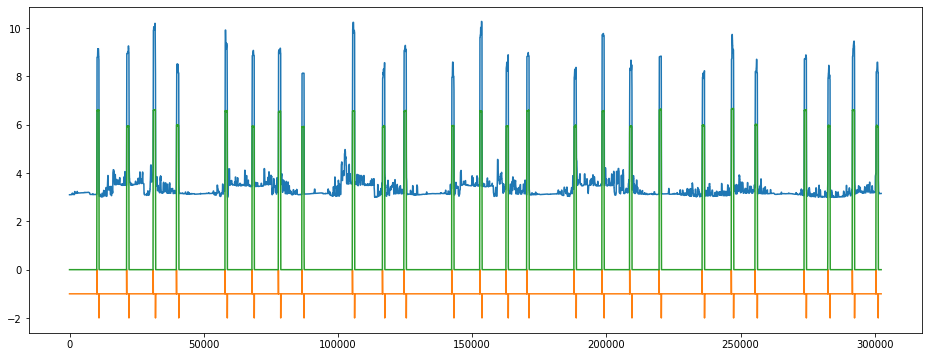

In [9]:
fig = plt.figure()

# plt.plot(pd.DataFrame(model.usp_data).iloc[: ])
plt.plot(pd.DataFrame(model.mdf_data).iloc[:])
plt.plot(pd.DataFrame(model.events_v).iloc[:])
plt.plot(pd.DataFrame(m.usp_data).iloc[:])

fig.set_size_inches(16, 6)
plt.show()

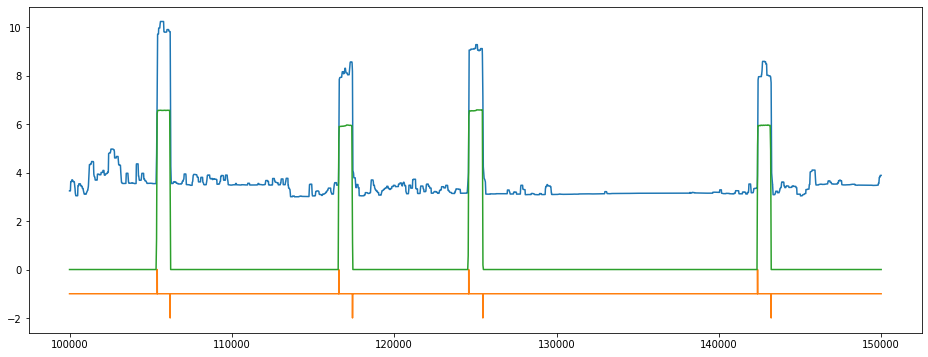

In [10]:
fig = plt.figure()

# plt.plot(pd.DataFrame(model.usp_data).iloc[: ])
plt.plot(pd.DataFrame(model.mdf_data).iloc[100000:150000])
plt.plot(pd.DataFrame(model.events_v).iloc[100000:150000])
plt.plot(pd.DataFrame(m.usp_data).iloc[100000:150000])

fig.set_size_inches(16, 6)
plt.show()